In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plantdisease:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F70909%2F150545%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240603%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240603T034037Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fafb482747c9c2ff581d51ed9df7daee1d87e45ccc35e4f676e9210b5ee04738ba8109b4b333d501d6f9382855f5eec8e2a05032e17f1e8abd4184f149f8ea0b1fc5433fc3711d4775f2b5628d6bfe57a1b0998b50e5743ec27d1f1a2031039cf091f8e93b0159ba3bf0f90f30f28a9738acbbc24ff1b7a578cf8668d4b7132e507a129709d198230cac56e070d0c107a701a73fe466613e1a77715277fa4372e98d21ce3c2dcb4fbb3fa447ebe8e152c21d6dc9b4757c639d939be52056c2a2880016ad46f9201672ecd6171073b5dca6bad822b24a3a92caf6a39ada3ea8305f1c100d0b6e253e08757502fe33e6547f0a15e0ae30df35bd815e214727ddc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 689512690 bytes downloaded
Downloaded and uncompressed: plantdisease
Data source import complete.


# Introduction

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
import tensorflow_hub as hub

In [ ]:
import os
import shutil

# Path ke direktori yang akan dihapus
directory_to_delete = '/kaggle/input/plantdisease/PlantVillage'
# List folder yang ada di dalam direktori
folders = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Iterasi melalui setiap folder dan hapus
for folder in folders:
    folder_path = os.path.join(directory_to_delete, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder {folder_path} berhasil dihapus.")
    else:
        print(f"Folder {folder_path} tidak ditemukan.")

print("Proses penghapusan selesai.")


Folder /kaggle/input/plantdisease/PlantVillage/Potato___Early_blight berhasil dihapus.
Folder /kaggle/input/plantdisease/PlantVillage/Potato___Late_blight berhasil dihapus.
Folder /kaggle/input/plantdisease/PlantVillage/Potato___healthy berhasil dihapus.
Proses penghapusan selesai.


In [ ]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
                 'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold',
                 'Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
                 'Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy'
                ]

data_dir = '../input/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(5)

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/836b4b9e-85d5-47...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/3bb93b52-4419-48...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/77a0bad6-8570-43...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/39d02156-2d42-49...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/4a18013a-dcd1-49...,0,Pepper__bell___Bacterial_spot


In [ ]:
list_kelas = train[['DiseaseID', 'Disease Type']].drop_duplicates()

# Urutkan DataFrame list_kelas berdasarkan DiseaseID
list_kelas = list_kelas.sort_values(by='DiseaseID').reset_index(drop=True)

# Tampilkan list_kelas
list_kelas.head(12)

,DiseaseID,Disease Type
0,0,Pepper__bell___Bacterial_spot
1,1,Pepper__bell___healthy
2,2,Tomato_Bacterial_spot
3,3,Tomato_Early_blight
4,4,Tomato_Late_blight
5,5,Tomato_Leaf_Mold
6,6,Tomato_Septoria_leaf_spot
7,7,Tomato_Spider_mites_Two_spotted_spider_mite
8,8,Tomato__Target_Spot
9,9,Tomato__Tomato_YellowLeaf__Curl_Virus


# Randomizing the Training Sample

In [ ]:
seed = 45
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,DiseaseID,Disease Type
16465,Tomato__Tomato_YellowLeaf__Curl_Virus/828b86cf...,9,Tomato__Tomato_YellowLeaf__Curl_Virus
1434,Pepper__bell___healthy/32ad9931-dd83-42be-9502...,1,Pepper__bell___healthy
11171,Tomato_Spider_mites_Two_spotted_spider_mite/9b...,7,Tomato_Spider_mites_Two_spotted_spider_mite
345,Pepper__bell___Bacterial_spot/3b9a94fb-856a-45...,0,Pepper__bell___Bacterial_spot
15274,Tomato__Tomato_YellowLeaf__Curl_Virus/162a2c9a...,9,Tomato__Tomato_YellowLeaf__Curl_Virus


**Let's create Helper functions for visualizing diseases**

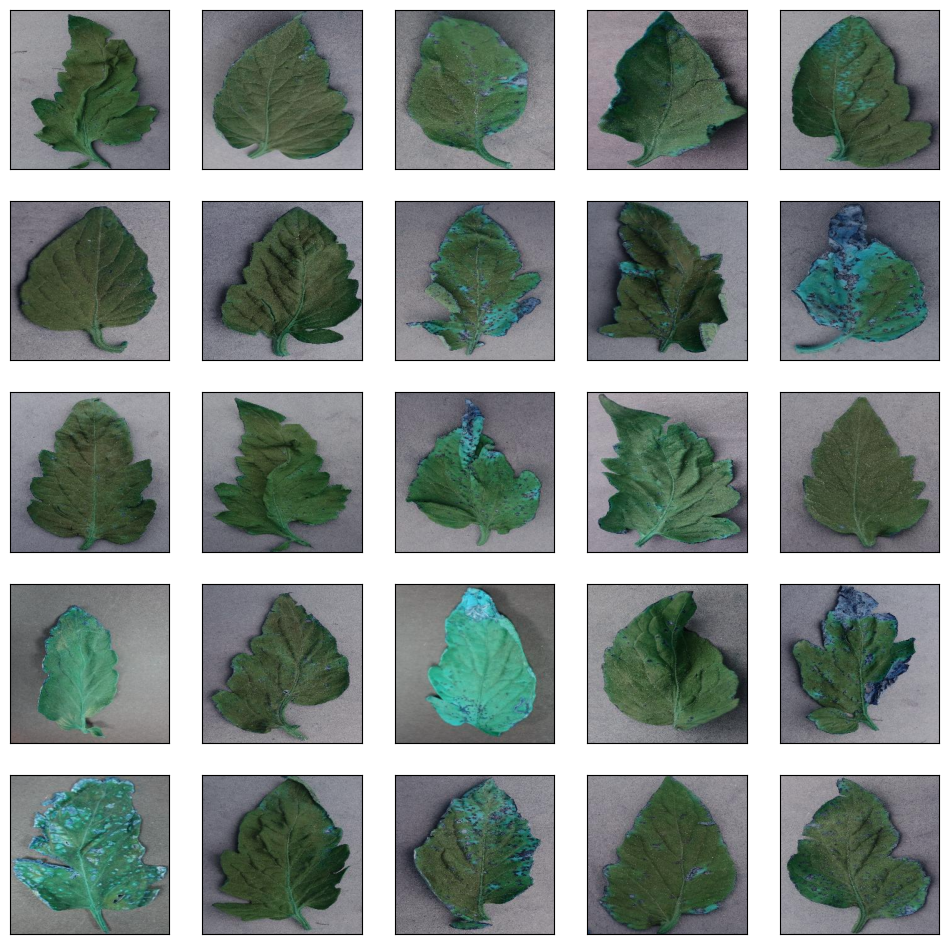

In [ ]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('Tomato_Bacterial_spot', 5, 5)

**Let's look at some healthy samples**

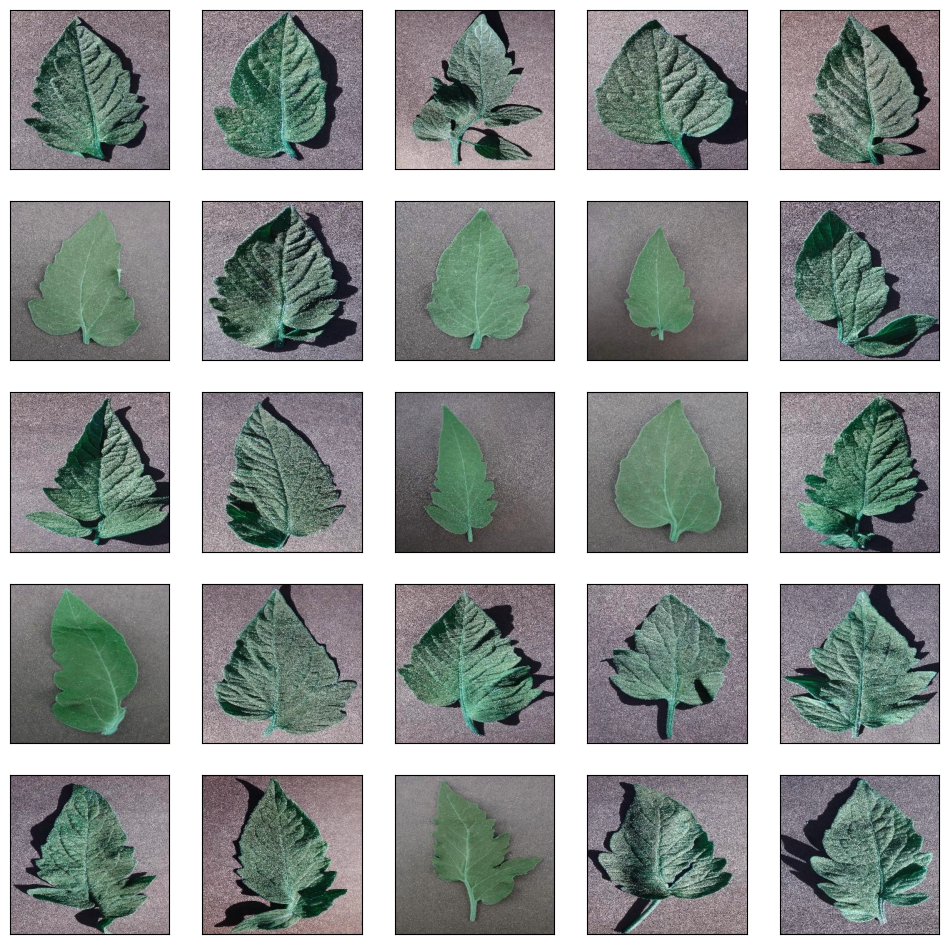

In [ ]:
disease_type('Tomato_healthy', 5, 5)

# Image Data Augmentation

In [ ]:
def create_image_data_generators(data_dir, image_size, batch_size, do_data_augmentation):
    # Inputs are suitably resized for the selected module.
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Validation generator
    validation_generator = datagen.flow_from_directory(
        data_dir,
        shuffle=False,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    if do_data_augmentation:
        # Enable data augmentation
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            horizontal_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')
    else:
        # Disable data augmentation
        train_datagen = datagen

    # Train generator
    train_generator = datagen.flow_from_directory(
        train_dir,
        subset="training",
        shuffle=True,
        seed=42,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_size,
        batch_size=batch_size)

    return train_generator, validation_generator

In [ ]:
data_dir = data_dir
train_dir = train_dir
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
do_data_augmentation = True
train_generator, validation_generator = create_image_data_generators(data_dir, IMAGE_SIZE, BATCH_SIZE, do_data_augmentation)

Found 18486 images belonging to 12 classes.
Found 14794 images belonging to 12 classes.


# Build Model

In [ ]:
module_selection = ("inception_v3", 299, 2048)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)

print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (224, 224) and output dimension 2048


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

if do_fine_tuning:
    feature_extractor.trainable = True
    # Unfreeze some layers of the base network for fine-tuning
    for layer in feature_extractor.layers[-30:]:
        layer.trainable = True
else:
    feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
Total params: 22858028 (87.20 MB)
Trainable params: 1055244 (4.03 MB)
Non-trainable params: 21802784 

# Specifying Loss Functions

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [ ]:
EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5


<ipython-input-33-2ce5b674b8b4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


462/462 [==============================] - 86s 164ms/step - loss: 1.0637 - accuracy: 0.6455 - val_loss: 0.5717 - val_accuracy: 0.8167
Epoch 2/5
462/462 [==============================] - 72s 157ms/step - loss: 0.7200 - accuracy: 0.7572 - val_loss: 0.4954 - val_accuracy: 0.8383
Epoch 3/5
462/462 [==============================] - 74s 159ms/step - loss: 0.6197 - accuracy: 0.7936 - val_loss: 0.4362 - val_accuracy: 0.8495
Epoch 4/5
462/462 [==============================] - 73s 159ms/step - loss: 0.5711 - accuracy: 0.8016 - val_loss: 0.4013 - val_accuracy: 0.8666
Epoch 5/5
462/462 [==============================] - 74s 161ms/step - loss: 0.5318 - accuracy: 0.8123 - val_loss: 0.3380 - val_accuracy: 0.8830


In [ ]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

<ipython-input-34-cd0e3ff311e6>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(validation_generator, steps=5)


578/578 [==============================] - 47s 81ms/step


In [ ]:
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       996
           1       0.96      0.97      0.97      1462
           2       0.93      0.86      0.90      2300
           3       0.70      0.78      0.74       902
           4       0.83      0.95      0.89      1668
           5       0.87      0.73      0.79      1134
           6       0.85      0.80      0.82      1871
           7       0.83      0.89      0.86      1575
           8       0.78      0.75      0.77      1463
           9       0.97      0.97      0.97      3196
          10       0.67      0.94      0.78       267
          11       0.96      0.92      0.94      1652

    accuracy                           0.88     18486
   macro avg       0.86      0.87      0.86     18486
weighted avg       0.89      0.88      0.88     18486



Text(0.5, 248.08159722222211, 'Predicted')

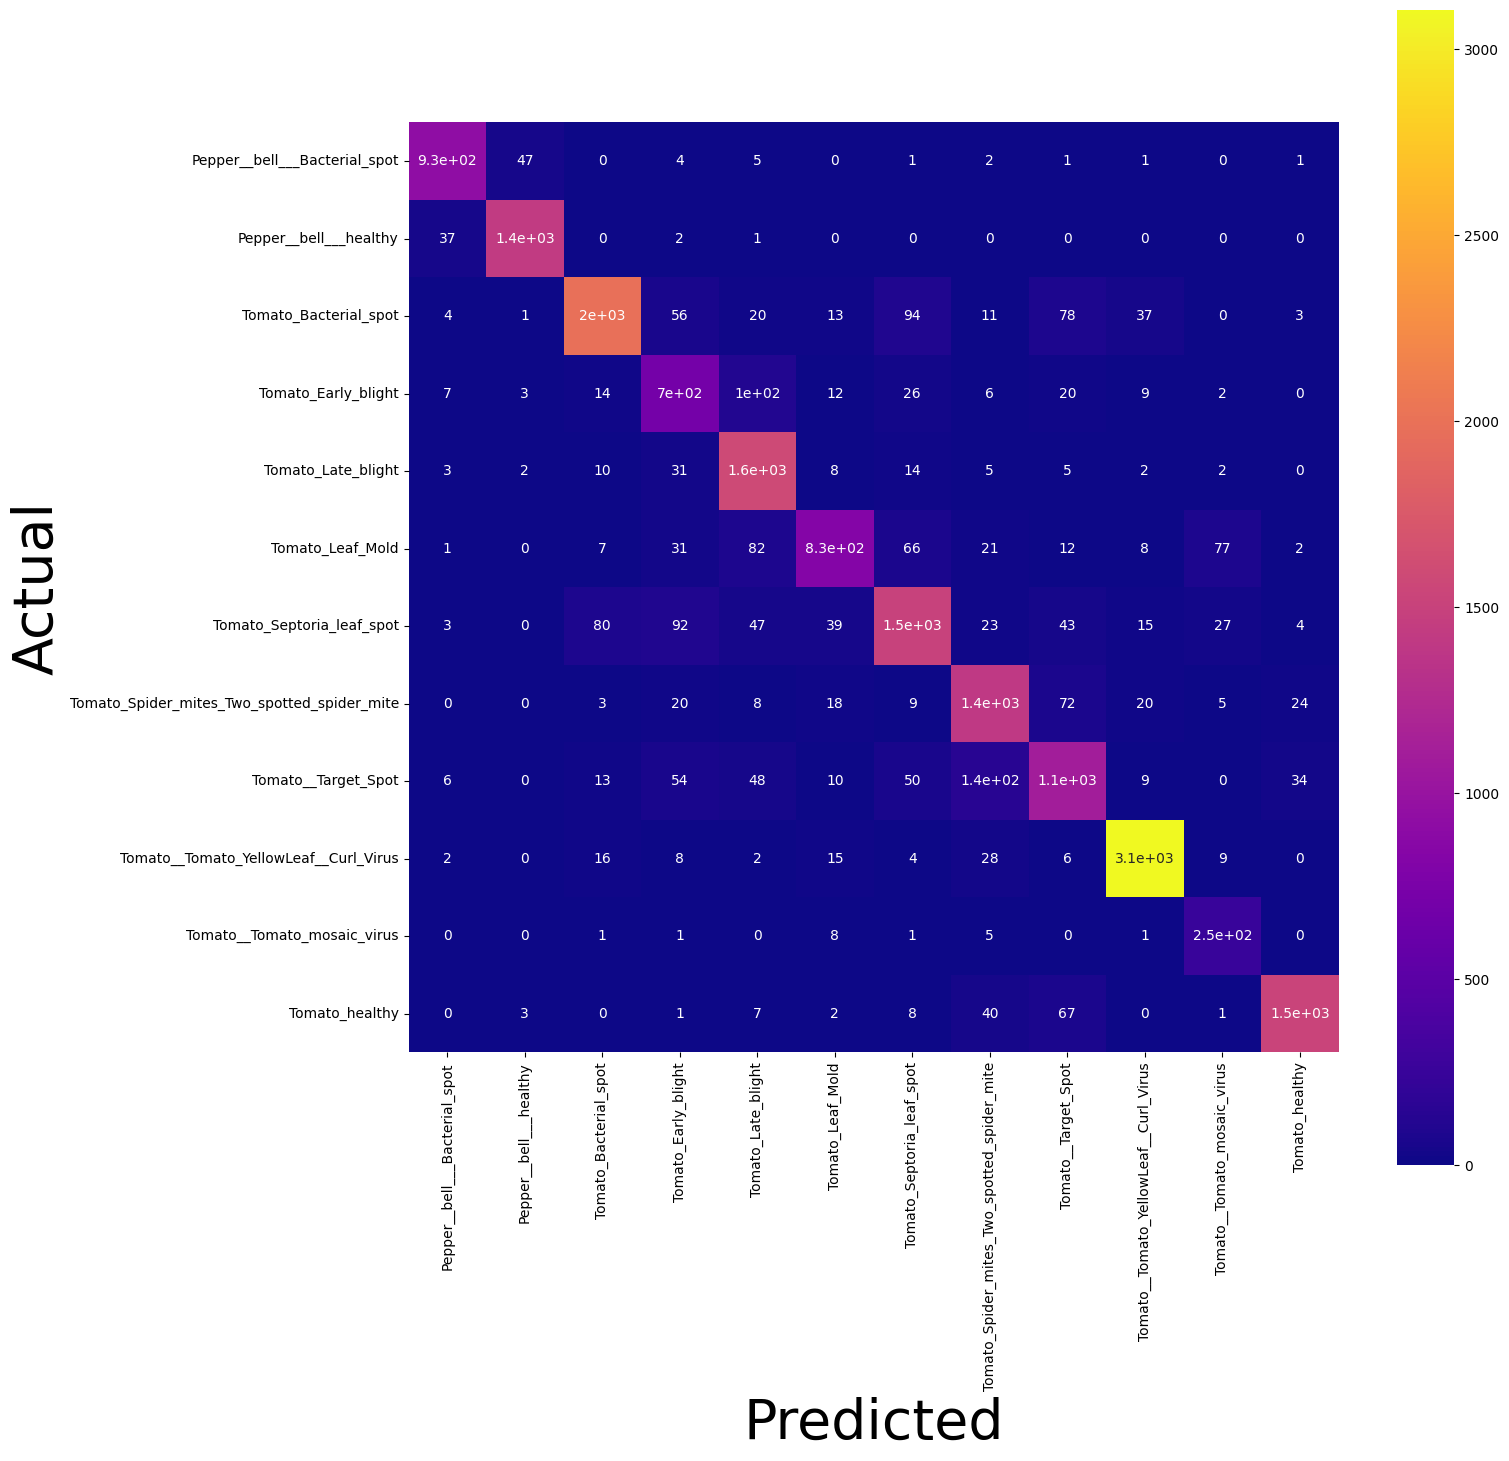

In [ ]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

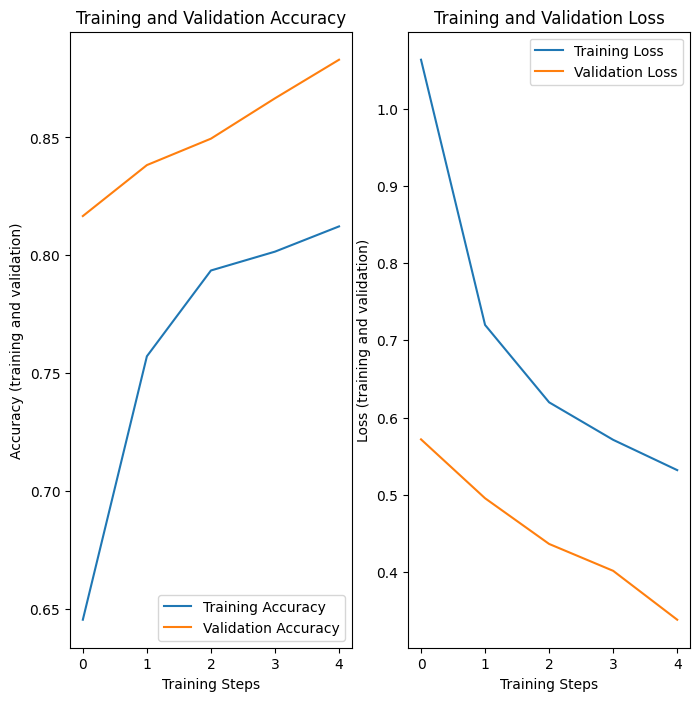

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

# Random Image testing

In [ ]:
image_path = '../input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0  # Normalize the input image

# Run inference
output_probs = model.predict(input_arr)

# Get predicted class index
preds1 = np.argmax(output_probs)

1/1 [==============================] - 4s 4s/step


In [ ]:
preds1

0

# Image testing v2

In [ ]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    img = img / 255.0  # Normalisasi nilai piksel
    return img


    return img
def predict(image):
    probabilities = model.predict(np.asarray([image]))[0]
    class_idx = np.argmax(probabilities)

    return {disease_types[class_idx]: probabilities[class_idx]}


1/1 [==============================] - 0s 26ms/step
Predicted class: Tomato__Tomato_YellowLeaf__Curl_Virus, confidence: 0.999577


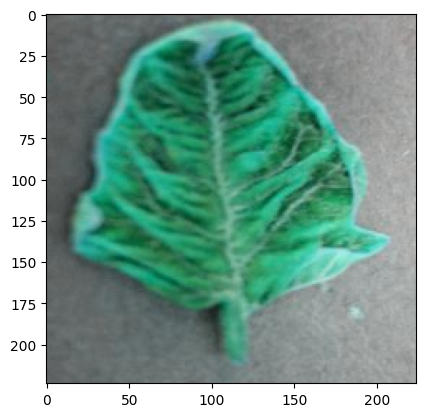

In [ ]:
# Load a single image
img = load_image('/TomatoYellowCurlVirus6.JPG')

# Predict the class of the image
prediction = predict(img)

# Print the prediction
print("Predicted class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

# Show the image
plt.imshow(img)
plt.show()


# Converting to Tensorflow Lite and modelh5

In [ ]:
path = "/content/model_v2.h5"
tf.saved_model.save(model, path)

## Cara Makai h5

In [ ]:
# Memuat kembali model dari TensorFlow SavedModel
loaded_model = tf.saved_model.load(path)


In [ ]:
image_path = '../input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e96-945c-a312002037bf___JR_B.Spot 3262.JPG'

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0  # Normalize the input image

# Run inference
output_probs = loaded_model(input_arr)

# Get predicted class index
preds1 = np.argmax(output_probs)
print(preds1)


0


In [ ]:
import shutil
import os
from zipfile import ZipFile
from google.colab import files as colab_files

# Path folder yang ingin Anda kompres
folder_path = "/content/model_v2.h5"

# Nama file zip yang akan dihasilkan
zip_file_name = "model-v1.zip"

# Kompres folder menjadi file zip
with ZipFile(zip_file_name, 'w') as zipf:
    for root, _, files in os.walk(folder_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(folder_path, '..')))

# Unduh file zip
colab_files.download(zip_file_name)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 89230KBs.


In [ ]:
 # Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))


Quantized model size = 22622KBs,
which is about 25% of the float model size.


In [ ]:
f = open('plant_model.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

## Cara makai TFlite

In [ ]:
tflite_model_path = "/content/plant_model.tflite"  # Ganti dengan path ke model TensorFlow Lite Anda
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()


In [ ]:
image_path = '/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0  # Normalisasi gambar input


In [ ]:
input_index = interpreter.get_input_details()[0]['index']
interpreter.set_tensor(input_index, input_arr)


In [ ]:
interpreter.invoke()


In [ ]:
class_names = [
    "Pepper__bell___Bacterial_spot", "Pepper__bell___healthy",
    "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
    "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
    "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato__Target_Spot",
    "Tomato__Tomato_YellowLeaf__Curl_Virus", "Tomato__Tomato_mosaic_virus",
    "Tomato_healthy"
]

In [ ]:
output_index = interpreter.get_output_details()[0]['index']
output = interpreter.get_tensor(output_index)
predicted_class_index = np.argmax(output)
predicted_class_name = class_names[predicted_class_index]
print(predicted_class_index)
print("Predicted class:", predicted_class_name)

0
Predicted class: Pepper__bell___Bacterial_spot


In [ ]:
from google.colab import files

# Tentukan path file yang ingin diunduh
file_path = "/content/plant_model.tflite"

# Unduh file
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Batas kesalahan

In [ ]:
from tensorflow.keras.models import load_model

# Memuat model dari file .h5
loaded_model = load_model("/content/my_model.h5",custom_objects={'KerasLayer':hub.KerasLayer}
)

OSError: No file or directory found at /content/my_model.h5

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

# Load the pre-trained InceptionV3 model from TensorFlow Hub
inception_v3 = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2', input_shape=(299, 299, 3))
])

# Load just the weights of the custom layers from plant_model.h5
custom_model = tf.keras.models.load_model("/content/plant_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})
custom_weights = custom_model.get_weights()

# Set the weights of the custom layers in the InceptionV3 base model
for layer in inception_v3.layers:
    if layer.name.startswith('your_custom_layer_prefix'):  # Replace 'your_custom_layer_prefix' with the prefix used in your custom model
        layer.set_weights(custom_weights)

# Combine the InceptionV3 base model with the custom layers
combined_model = tf.keras.Sequential([
    inception_v3,
    tf.keras.layers.Flatten(),  # Add a Flatten layer if needed
    # Add more layers as needed
])

# Continue with the rest of your code for image preprocessing and inference


### Upload model

In [ ]:
from google.colab import files

model_path = files.upload()

Saving plant_model.tflite to plant_model (1).tflite


### Coba generate api


In [ ]:
!pip install -q -U google-generativeai

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
model = genai.GenerativeModel('gemini-pro')

In [ ]:
response = model.generate_content("Hello")
print(response.text)

Hi there! How can I assist you today?


## Implementasi model dan gemini

In [ ]:
def predict_image(model_path, image_path):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Load image and preprocess
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.expand_dims(input_arr, axis=0)
    input_arr = input_arr / 255.0  # Normalize the input image

    # Set input tensor
    input_index = interpreter.get_input_details()[0]['index']
    interpreter.set_tensor(input_index, input_arr)

    # Invoke interpreter
    interpreter.invoke()

    # Get output tensor and predicted class
    output_index = interpreter.get_output_details()[0]['index']
    output = interpreter.get_tensor(output_index)
    predicted_class_index = np.argmax(output)

    class_names = [
        "Pepper_bell_Bacterial_spot", "Pepper_bell_healthy",
        "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight",
        "Tomato_Leaf_Mold", "Tomato_Septoria_leaf_spot",
        "Tomato_Spider_mites_Two_spotted_spider_mite", "Tomato_Target_Spot",
        "Tomato_YellowLeaf_Curl_Virus", "Tomato_Tomato_mosaic_virus",
        "Tomato_healthy"
    ]

    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

In [ ]:
def prompt_disease(disease):
    # Dapatkan kunci API Google Anda dari userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

    # Konfigurasi kunci API
    genai.configure(api_key=GOOGLE_API_KEY)

    # Buat instance model GenerativeModel untuk Gemini
    model = genai.GenerativeModel('gemini-pro')

    # Prompt berdasarkan penyakit
    prompt = f"Jelaskan Penyakit {disease}: Pengertian, Penyebab, dan Cara Penanganan singkat dalam 3 paragraf."

    # Gunakan model untuk menghasilkan konten berdasarkan prompt
    response = model.generate_content(prompt)

    # Cetak hasil konten yang dihasilkan
    return response.text


In [ ]:
def main():
    model_path = "/content/plant_model.tflite"
    image_path = "/content/TomatoYellowCurlVirus6.JPG"
    predicted_class = predict_image(model_path, image_path)
    print(prompt_disease(predicted_class))

if __name__ == "__main__":
    main()


Penyakit Tomato Yellow Leaf Curl Virus (TYLCV) adalah penyakit virus yang menyerang tanaman tomat, menyebabkan kerusakan parah pada hasil panen. Virus ini ditularkan melalui lalat putih dan dapat menyebabkan kerugian ekonomi yang signifikan bagi petani.

Gejala TYLCV meliputi daun menggulung ke atas, menjadi kuning, dan keriting. Tanaman yang terinfeksi juga dapat menunjukkan pertumbuhan kerdil, penurunan hasil, dan kualitas buah yang menurun. Penyakit ini dapat menyebabkan kerugian hingga 100% pada tanaman yang terinfeksi.

Cara penanganan TYLCV meliputi penggunaan varietas tahan, pengendalian lalat putih dengan insektisida, dan sanitasi kebun. Menanam tomat dalam naungan juga dapat membantu mengurangi penyebaran virus. Selain itu, petani dapat menggunakan mulsa reflektif untuk mengusir lalat putih dan menanam tanaman perangkap seperti mustard untuk menarik serangga tersebut dari tanaman tomat.
